# ResNet50 Furniture Classification Experiments

This notebook trains ResNet50 on furniture profitability classification with three data configurations:
- **all**: All data in dataset
- **high_quality**: High confidence predictions (≥0.8 confidence score for any tabular column)
- **brand_msrp_only**: Only listings with known brand and MSRP data

In [2]:
# Login to HuggingFace to access private dataset
from huggingface_hub import login
login()

In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path

from experiments.dataset_utils import load_and_split_hf_data, get_hf_data_loaders, DATASET_REPO
from experiments.training_utils import (
    train_model, evaluate_model, plot_training_history, 
    plot_confusion_matrix, visualize_misclassified,
    save_experiment_results, print_experiment_summary
)

# Set random seeds for reproducability across experiments
torch.manual_seed(42)
np.random.seed(42)

# Device config
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
RESULTS_DIR = Path('results/resnet50')
MODELS_DIR = Path('models/resnet50')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using HuggingFace dataset: {DATASET_REPO}")

Using device: CUDA - Tesla V100-SXM2-16GB

✓ Using HuggingFace dataset: adybacki/furniture-profitability-dataset
  Images will be cached automatically for 10-20x speedup!


## Data Transforms

In [ ]:
# ResNet50 expects 224x224 images with ImageNet normalization
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

## Model Definition

In [ ]:
def create_resnet50_model():
    """
    Create ResNet50 model for binary classification
    """
    # Load pre-trained ResNet50
    model = models.resnet50(pretrained=True)
    

    for param in model.parameters():
        param.requires_grad = False

    # ResNet50 outputs 2048 features (already pooled)
    num_features = model.fc.in_features  # 2048
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)
    )
    
    return model

## Training Configuration

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Data modes to test
DATA_MODES = ['all', 'high_quality', 'brand_msrp_only']

## Experiment Loop

Run experiments for all three data configurations


EXPERIMENT: ResNet50 with ALL data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
✓ Loaded 26,554 total samples

Filtering for data_mode: all
✓ 26,554 samples after filtering

Original class distribution: {0: 18078, 1: 8476}
Balancing classes to 8476 samples each...
Balanced class distribution: {0: 8476, 1: 8476}

Train samples: 13561
Validation samples: 1695
Test samples: 1696
Dataset initialized with 13561 samples
Class distribution: {1: 6781, 0: 6780}
Dataset initialized with 1695 samples
Class distribution: {0: 848, 1: 847}
Dataset initialized with 1696 samples
Class distribution: {0: 848, 1: 848}

Training resnet50_all



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 90.10s
────────────────────────────────────────────────────────────
Train - Loss: 0.6805 | Acc: 0.5594 | F1: 0.5563
Val   - Loss: 0.6704 | Acc: 0.5923 | F1: 0.6054
🏆 New best model saved (F1: 0.6054)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 89.79s
────────────────────────────────────────────────────────────
Train - Loss: 0.6673 | Acc: 0.5939 | F1: 0.5944
Val   - Loss: 0.6623 | Acc: 0.6053 | F1: 0.6222
🏆 New best model saved (F1: 0.6222)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 89.77s
────────────────────────────────────────────────────────────
Train - Loss: 0.6585 | Acc: 0.6069 | F1: 0.6084
Val   - Loss: 0.6632 | Acc: 0.5947 | F1: 0.5788
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 89.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6518 | Acc: 0.6142 | F1: 0.6156
Val   - Loss: 0.6607 | Acc: 0.5965 | F1: 0.5570
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 89.71s
────────────────────────────────────────────────────────────
Train - Loss: 0.6476 | Acc: 0.6190 | F1: 0.6198
Val   - Loss: 0.6583 | Acc: 0.5959 | F1: 0.5906
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 89.43s
────────────────────────────────────────────────────────────
Train - Loss: 0.6428 | Acc: 0.6259 | F1: 0.6293
Val   - Loss: 0.6587 | Acc: 0.6029 | F1: 0.5727
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 89.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.6390 | Acc: 0.6330 | F1: 0.6347
Val   - Loss: 0.6550 | Acc: 0.6053 | F1: 0.6104
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 89.51s
────────────────────────────────────────────────────────────
Train - Loss: 0.6330 | Acc: 0.6408 | F1: 0.6423
Val   - Loss: 0.6551 | Acc: 0.6088 | F1: 0.6196
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 89.32s
────────────────────────────────────────────────────────────
Train - Loss: 0.6284 | Acc: 0.6429 | F1: 0.6465
Val   - Loss: 0.6567 | Acc: 0.5988 | F1: 0.6214
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 89.23s
────────────────────────────────────────────────────────────
Train - Loss: 0.6256 | Acc: 0.6444 | F1: 0.6473
Val   - Loss: 0.6567 | Acc: 0.6018 | F1: 0.5877
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 89.20s
────────────────────────────────────────────────────────────
Train - Loss: 0.6200 | Acc: 0.6527 | F1: 0.6547
Val   - Loss: 0.6571 | Acc: 0.6059 | F1: 0.6420
🏆 New best model saved (F1: 0.6420)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 88.91s
────────────────────────────────────────────────────────────
Train - Loss: 0.6181 | Acc: 0.6561 | F1: 0.6589
Val   - Loss: 0.6591 | Acc: 0.5988 | F1: 0.5485
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 89.03s
────────────────────────────────────────────────────────────
Train - Loss: 0.6111 | Acc: 0.6628 | F1: 0.6620
Val   - Loss: 0.6590 | Acc: 0.5988 | F1: 0.6462
🏆 New best model saved (F1: 0.6462)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 89.37s
────────────────────────────────────────────────────────────
Train - Loss: 0.6046 | Acc: 0.6750 | F1: 0.6789
Val   - Loss: 0.6551 | Acc: 0.6112 | F1: 0.6417
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 89.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.5996 | Acc: 0.6791 | F1: 0.6830
Val   - Loss: 0.6554 | Acc: 0.6094 | F1: 0.6129
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - resnet50_all
Best Validation F1: 0.6462
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: all

Test Set Performance:
  Accuracy:  0.5967
  F1 Score:  0.6404
  Precision: 0.5778
  Recall:    0.7182



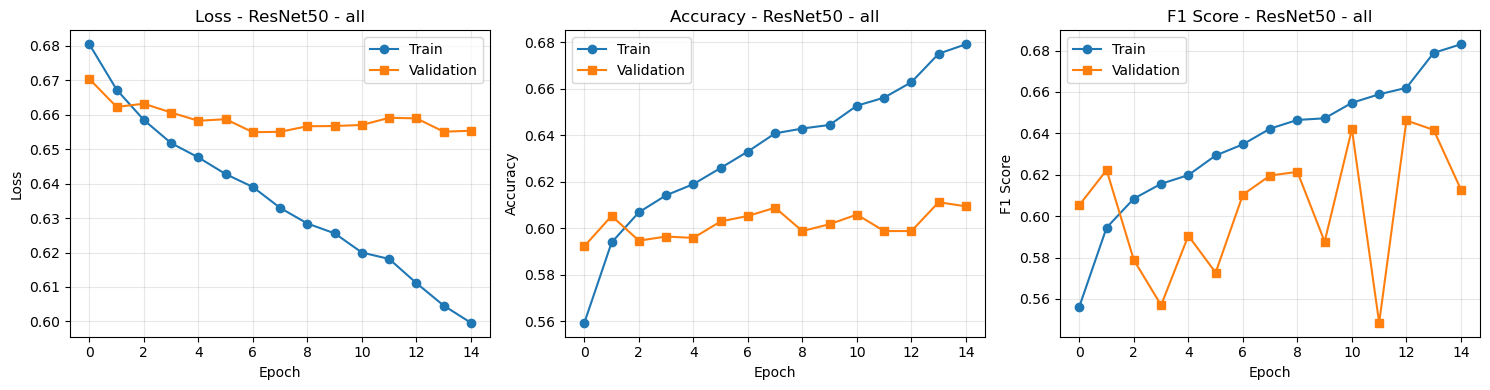

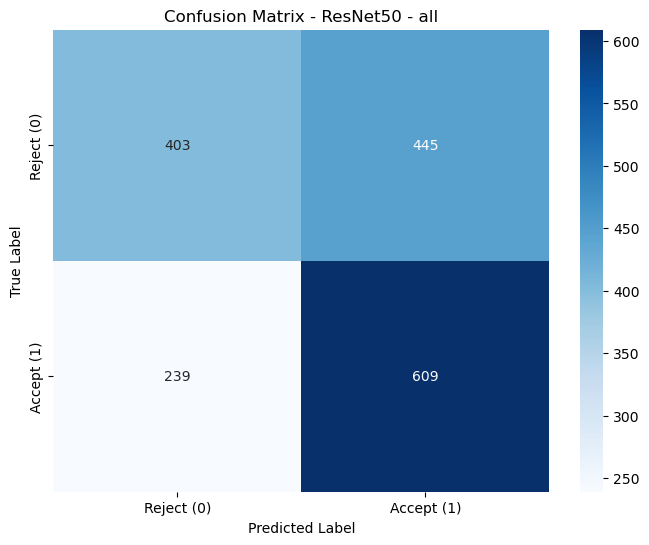


Analyzing misclassified examples...


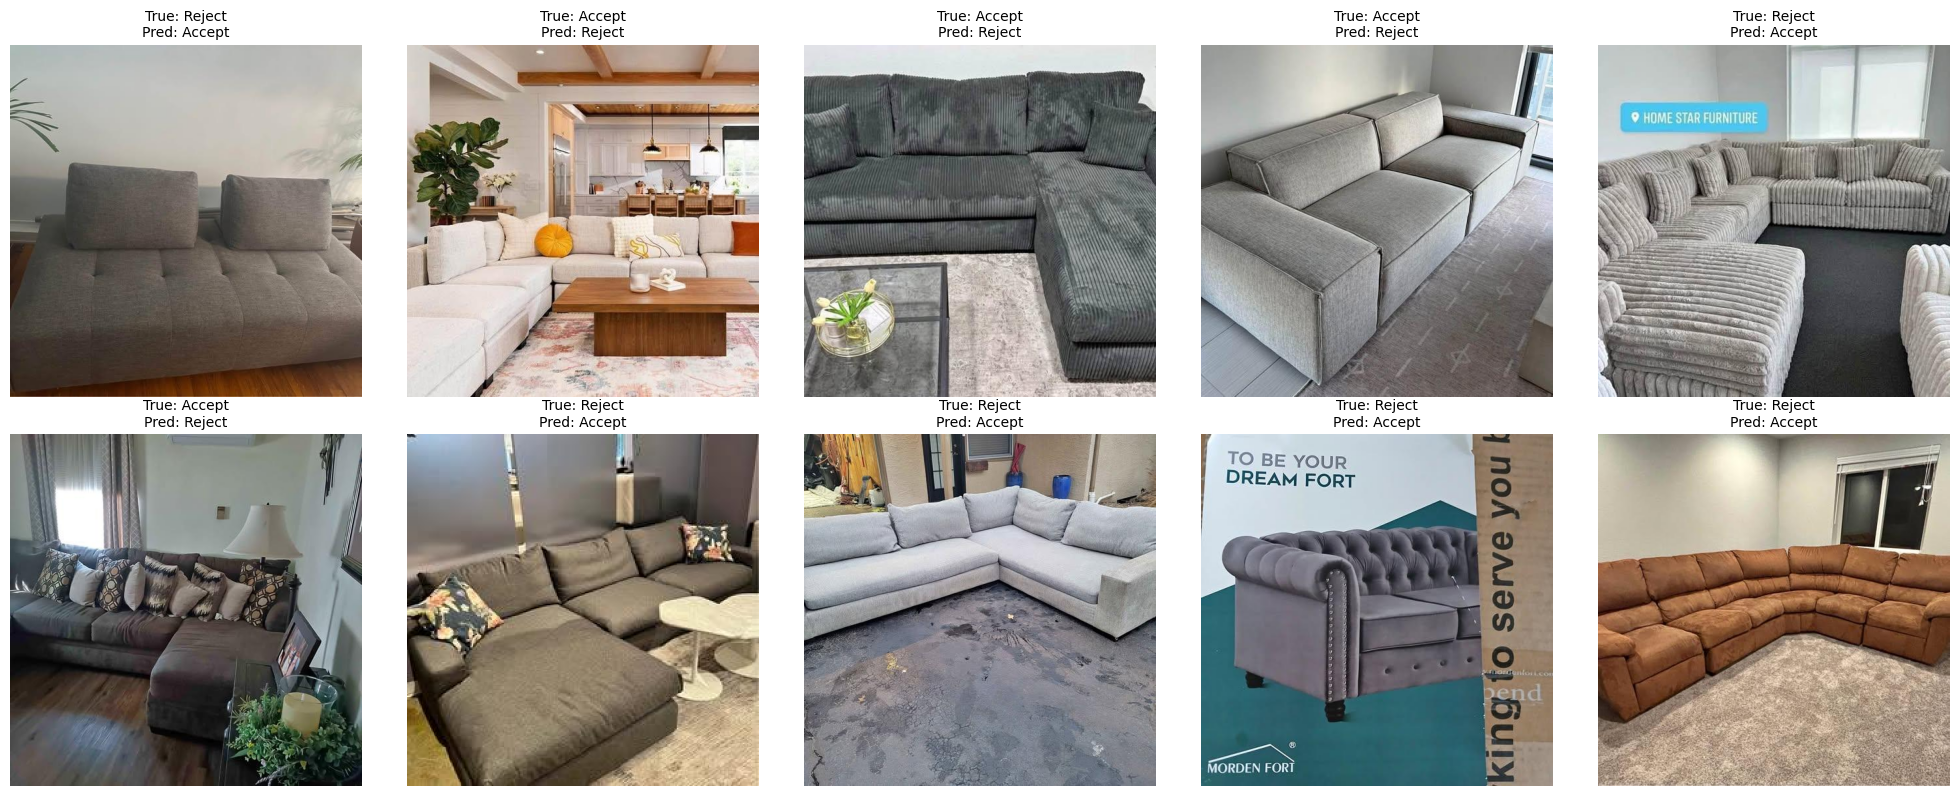

Results saved to results/resnet50/resnet50_all_results.json

EXPERIMENT: ResNet50 with HIGH_QUALITY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
✓ Loaded 26,554 total samples

Filtering for data_mode: high_quality
✓ 12,846 samples after filtering

Original class distribution: {0: 6437, 1: 6409}

Train samples: 10276
Validation samples: 1285
Test samples: 1285
Dataset initialized with 10276 samples
Class distribution: {0: 5149, 1: 5127}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}

Training resnet50_high_quality



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 67.80s
────────────────────────────────────────────────────────────
Train - Loss: 0.6777 | Acc: 0.5720 | F1: 0.5638
Val   - Loss: 0.6621 | Acc: 0.5992 | F1: 0.5414
🏆 New best model saved (F1: 0.5414)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 67.26s
────────────────────────────────────────────────────────────
Train - Loss: 0.6560 | Acc: 0.6112 | F1: 0.6140
Val   - Loss: 0.6502 | Acc: 0.6078 | F1: 0.6105
🏆 New best model saved (F1: 0.6105)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 67.15s
────────────────────────────────────────────────────────────
Train - Loss: 0.6469 | Acc: 0.6190 | F1: 0.6257
Val   - Loss: 0.6455 | Acc: 0.6101 | F1: 0.5897
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 67.18s
────────────────────────────────────────────────────────────
Train - Loss: 0.6371 | Acc: 0.6310 | F1: 0.6362
Val   - Loss: 0.6499 | Acc: 0.6101 | F1: 0.5578
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 67.85s
────────────────────────────────────────────────────────────
Train - Loss: 0.6286 | Acc: 0.6355 | F1: 0.6411
Val   - Loss: 0.6433 | Acc: 0.6156 | F1: 0.6501
🏆 New best model saved (F1: 0.6501)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 69.03s
────────────────────────────────────────────────────────────
Train - Loss: 0.6235 | Acc: 0.6467 | F1: 0.6534
Val   - Loss: 0.6430 | Acc: 0.6202 | F1: 0.6464
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 69.02s
────────────────────────────────────────────────────────────
Train - Loss: 0.6177 | Acc: 0.6552 | F1: 0.6618
Val   - Loss: 0.6472 | Acc: 0.6218 | F1: 0.6716
🏆 New best model saved (F1: 0.6716)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 69.05s
────────────────────────────────────────────────────────────
Train - Loss: 0.6151 | Acc: 0.6548 | F1: 0.6622
Val   - Loss: 0.6389 | Acc: 0.6319 | F1: 0.6403
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 69.33s
────────────────────────────────────────────────────────────
Train - Loss: 0.6077 | Acc: 0.6667 | F1: 0.6738
Val   - Loss: 0.6422 | Acc: 0.6226 | F1: 0.6426
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 69.13s
────────────────────────────────────────────────────────────
Train - Loss: 0.6029 | Acc: 0.6680 | F1: 0.6722
Val   - Loss: 0.6391 | Acc: 0.6304 | F1: 0.6605
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 68.98s
────────────────────────────────────────────────────────────
Train - Loss: 0.5994 | Acc: 0.6691 | F1: 0.6761
Val   - Loss: 0.6367 | Acc: 0.6327 | F1: 0.6248
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 67.61s
────────────────────────────────────────────────────────────
Train - Loss: 0.5939 | Acc: 0.6842 | F1: 0.6921
Val   - Loss: 0.6379 | Acc: 0.6335 | F1: 0.6385
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 67.19s
────────────────────────────────────────────────────────────
Train - Loss: 0.5883 | Acc: 0.6830 | F1: 0.6875
Val   - Loss: 0.6405 | Acc: 0.6420 | F1: 0.6695
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 67.26s
────────────────────────────────────────────────────────────
Train - Loss: 0.5831 | Acc: 0.6858 | F1: 0.6928
Val   - Loss: 0.6482 | Acc: 0.6342 | F1: 0.6362
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 67.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.5795 | Acc: 0.6951 | F1: 0.7015
Val   - Loss: 0.6450 | Acc: 0.6288 | F1: 0.6322
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - resnet50_high_quality
Best Validation F1: 0.6716
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: high_quality

Test Set Performance:
  Accuracy:  0.6109
  F1 Score:  0.6697
  Precision: 0.5808
  Recall:    0.7910



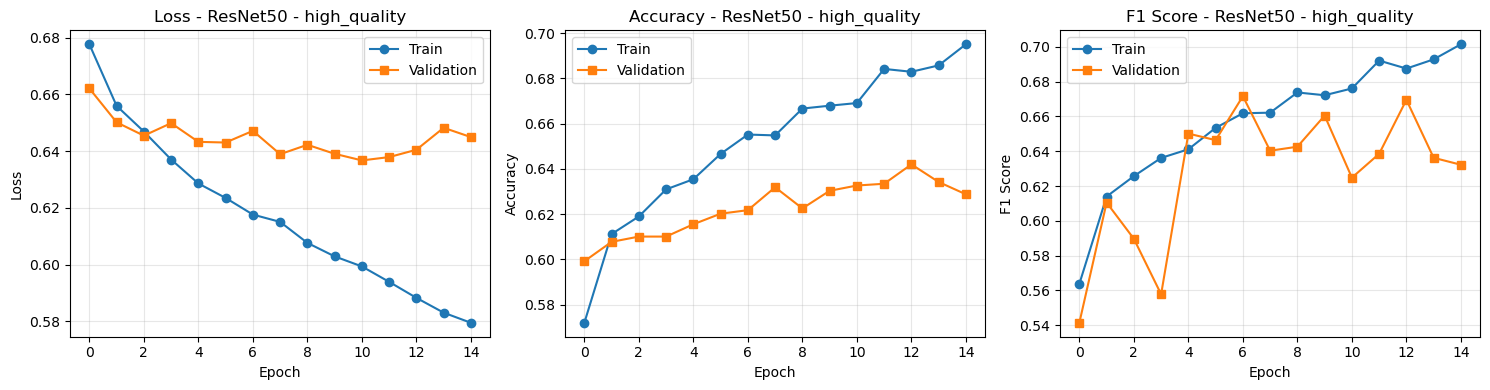

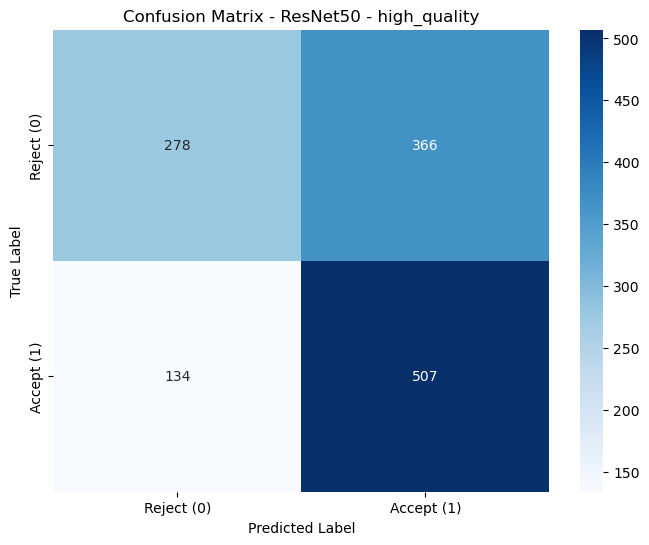


Analyzing misclassified examples...


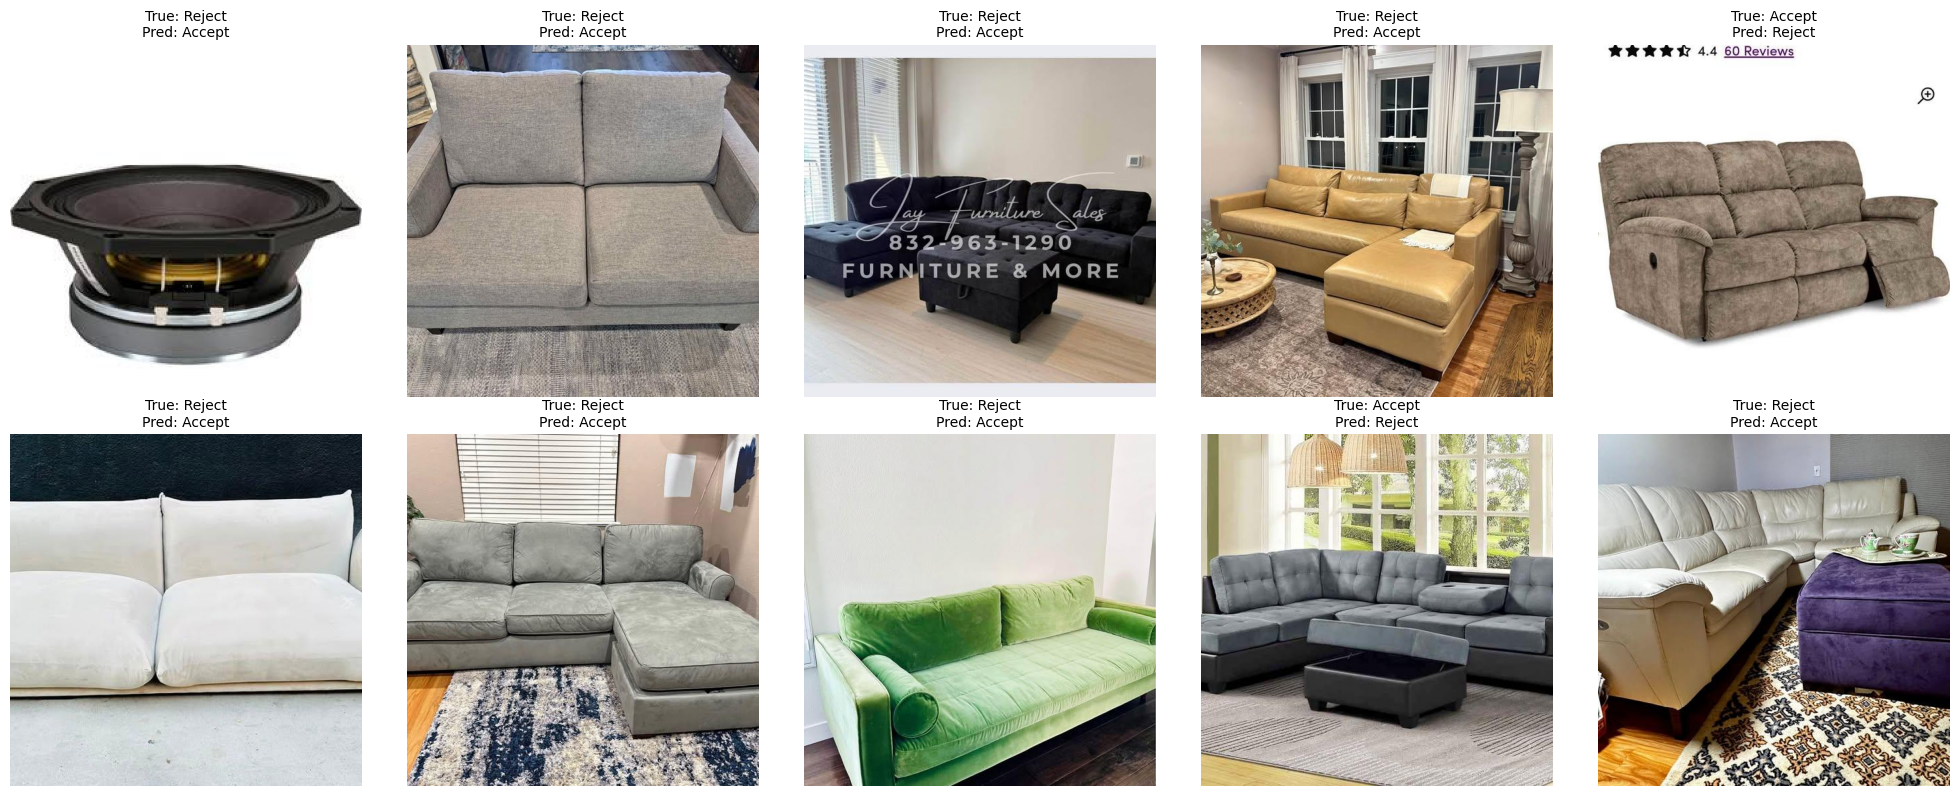

Results saved to results/resnet50/resnet50_high_quality_results.json

EXPERIMENT: ResNet50 with BRAND_MSRP_ONLY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
✓ Loaded 26,554 total samples

Filtering for data_mode: brand_msrp_only
✓ 5,209 samples after filtering

Original class distribution: {1: 3499, 0: 1710}
Balancing classes to 1710 samples each...
Balanced class distribution: {1: 1710, 0: 1710}

Train samples: 2736
Validation samples: 342
Test samples: 342
Dataset initialized with 2736 samples
Class distribution: {0: 1368, 1: 1368}
Dataset initialized with 342 samples
Class distribution: {0: 171, 1: 171}
Dataset initialized with 342 samples
Class distribution: {1: 171, 0: 171}

Training resnet50_brand_msrp_only



────────────────────────────────────────────────────────────
✓ EPOCH 1/15 COMPLETE - Time: 18.11s
────────────────────────────────────────────────────────────
Train - Loss: 0.6798 | Acc: 0.5647 | F1: 0.5860
Val   - Loss: 0.6612 | Acc: 0.6287 | F1: 0.6613
🏆 New best model saved (F1: 0.6613)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 2/15 COMPLETE - Time: 18.75s
────────────────────────────────────────────────────────────
Train - Loss: 0.6490 | Acc: 0.6327 | F1: 0.6432
Val   - Loss: 0.6440 | Acc: 0.6345 | F1: 0.6819
🏆 New best model saved (F1: 0.6819)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 3/15 COMPLETE - Time: 18.85s
────────────────────────────────────────────────────────────
Train - Loss: 0.6343 | Acc: 0.6433 | F1: 0.6497
Val   - Loss: 0.6385 | Acc: 0.6462 | F1: 0.6824
🏆 New best model saved (F1: 0.6824)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 4/15 COMPLETE - Time: 18.78s
────────────────────────────────────────────────────────────
Train - Loss: 0.6176 | Acc: 0.6608 | F1: 0.6737
Val   - Loss: 0.6328 | Acc: 0.6374 | F1: 0.6457
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 5/15 COMPLETE - Time: 18.76s
────────────────────────────────────────────────────────────
Train - Loss: 0.6082 | Acc: 0.6707 | F1: 0.6760
Val   - Loss: 0.6270 | Acc: 0.6316 | F1: 0.6272
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 6/15 COMPLETE - Time: 18.75s
────────────────────────────────────────────────────────────
Train - Loss: 0.5978 | Acc: 0.6784 | F1: 0.6805
Val   - Loss: 0.6193 | Acc: 0.6491 | F1: 0.6685
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 7/15 COMPLETE - Time: 18.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.5905 | Acc: 0.6915 | F1: 0.6953
Val   - Loss: 0.6194 | Acc: 0.6462 | F1: 0.6513
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 8/15 COMPLETE - Time: 18.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.5833 | Acc: 0.6933 | F1: 0.6948
Val   - Loss: 0.6189 | Acc: 0.6404 | F1: 0.6328
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 9/15 COMPLETE - Time: 18.33s
────────────────────────────────────────────────────────────
Train - Loss: 0.5693 | Acc: 0.7003 | F1: 0.7055
Val   - Loss: 0.6169 | Acc: 0.6637 | F1: 0.6761
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 10/15 COMPLETE - Time: 18.25s
────────────────────────────────────────────────────────────
Train - Loss: 0.5701 | Acc: 0.6959 | F1: 0.7007
Val   - Loss: 0.6202 | Acc: 0.6608 | F1: 0.6778
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 11/15 COMPLETE - Time: 18.30s
────────────────────────────────────────────────────────────
Train - Loss: 0.5600 | Acc: 0.6988 | F1: 0.7006
Val   - Loss: 0.6153 | Acc: 0.6696 | F1: 0.6921
🏆 New best model saved (F1: 0.6921)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 12/15 COMPLETE - Time: 18.29s
────────────────────────────────────────────────────────────
Train - Loss: 0.5577 | Acc: 0.7105 | F1: 0.7147
Val   - Loss: 0.6180 | Acc: 0.6491 | F1: 0.6891
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 13/15 COMPLETE - Time: 18.36s
────────────────────────────────────────────────────────────
Train - Loss: 0.5411 | Acc: 0.7153 | F1: 0.7235
Val   - Loss: 0.6162 | Acc: 0.6608 | F1: 0.6667
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 14/15 COMPLETE - Time: 18.22s
────────────────────────────────────────────────────────────
Train - Loss: 0.5391 | Acc: 0.7244 | F1: 0.7256
Val   - Loss: 0.6248 | Acc: 0.6257 | F1: 0.6098
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
✓ EPOCH 15/15 COMPLETE - Time: 18.69s
────────────────────────────────────────────────────────────
Train - Loss: 0.5307 | Acc: 0.7325 | F1: 0.7344
Val   - Loss: 0.6198 | Acc: 0.6550 | F1: 0.6758
────────────────────────────────────────────────────────────

✓ TRAINING COMPLETE - resnet50_brand_msrp_only
Best Validation F1: 0.6921
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: brand_msrp_only

Test Set Performance:
  Accuracy:  0.6345
  F1 Score:  0.6398
  Precision: 0.6307
  Recall:    0.6491



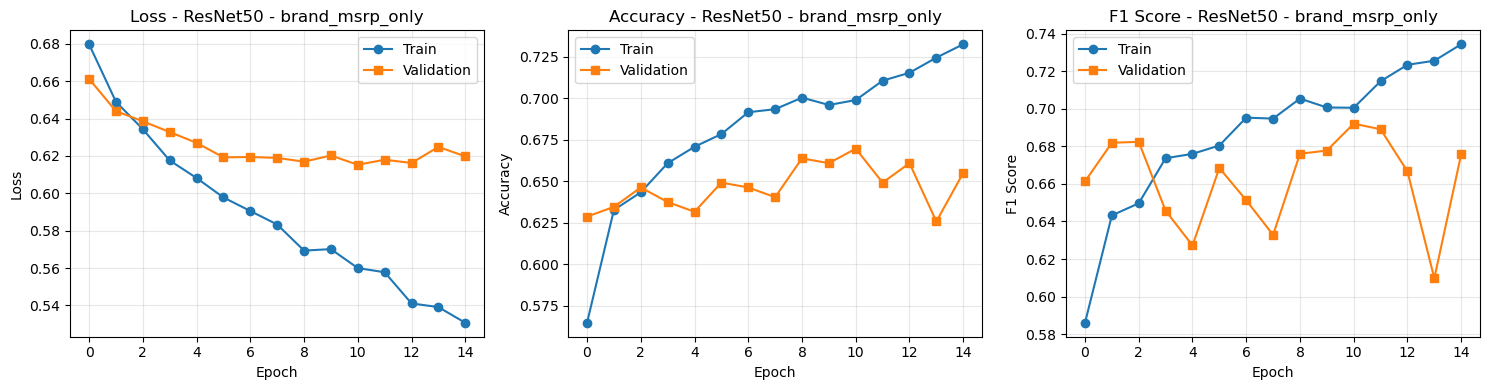

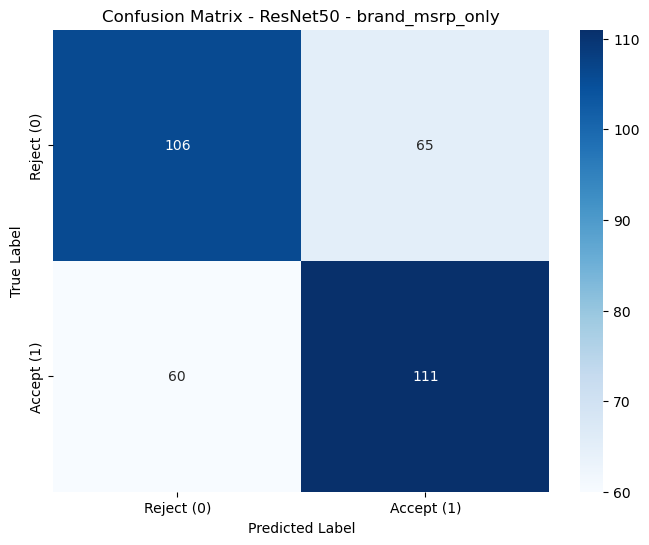


Analyzing misclassified examples...


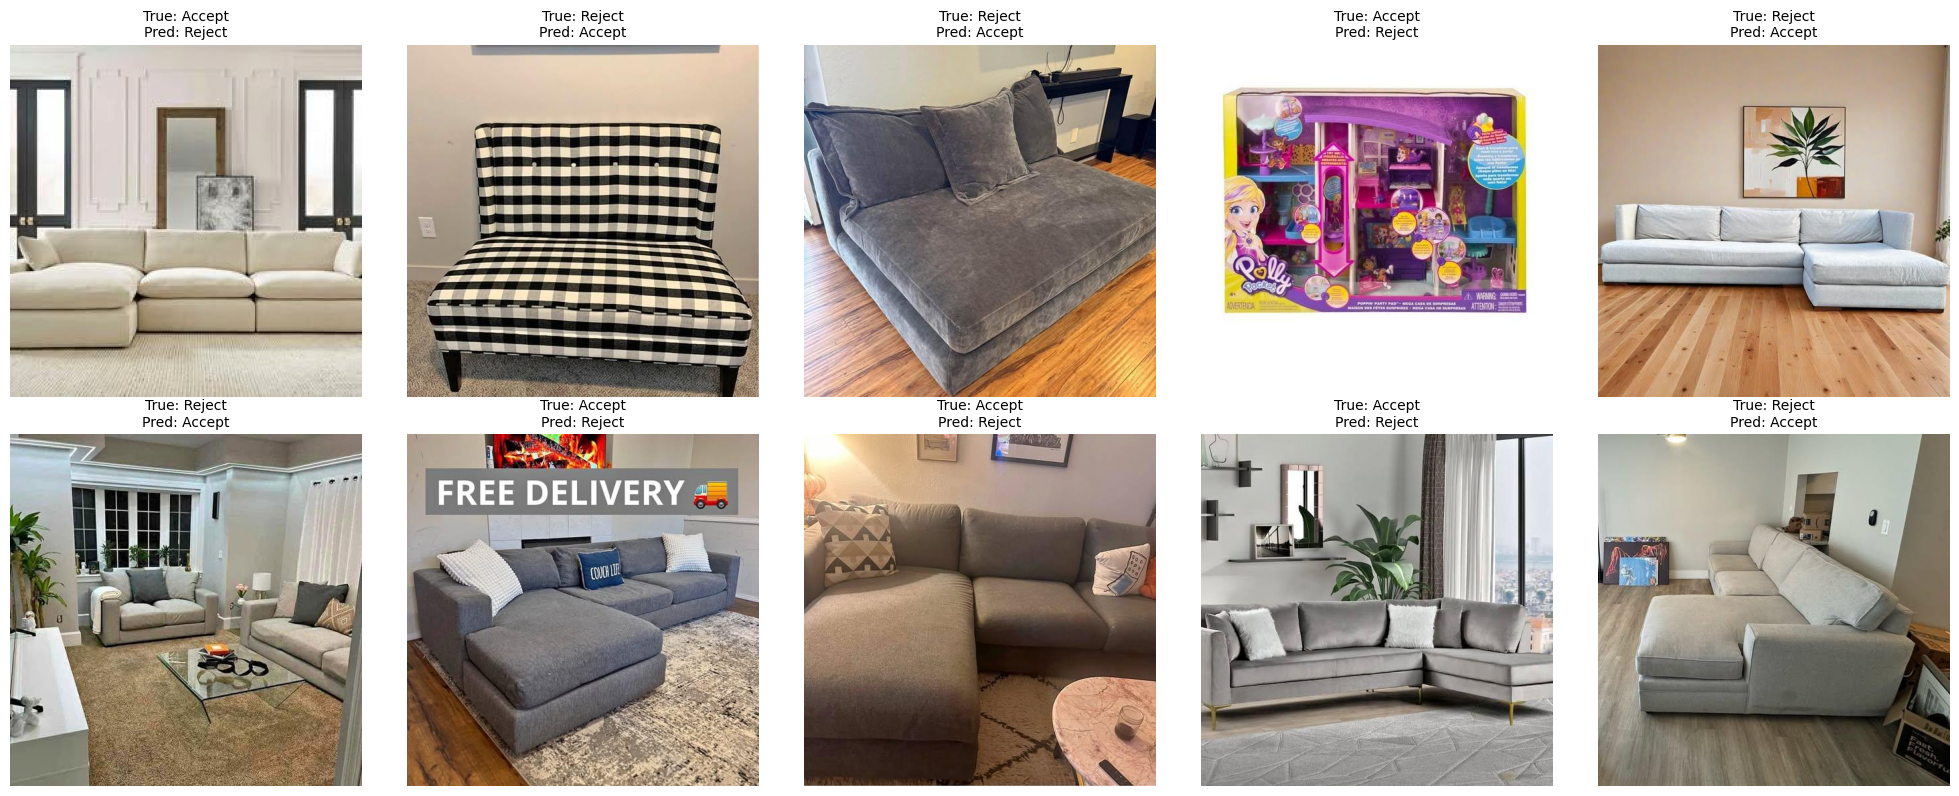

Results saved to results/resnet50/resnet50_brand_msrp_only_results.json


In [ ]:
all_results = {}

for data_mode in DATA_MODES:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: ResNet50 with {data_mode.upper()} data")
    print(f"{'='*80}\n")
    
    # Load and split data from HuggingFace
    train_idx, val_idx, test_idx, hf_dataset = load_and_split_hf_data(
        DATASET_REPO,
        data_mode=data_mode,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_hf_data_loaders(
        train_idx, val_idx, test_idx, hf_dataset,
        transform, transform,
        batch_size=BATCH_SIZE
    )
    
    # Create model
    model = create_resnet50_model()
    model = model.to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
    
    # Train model
    model_name = f"resnet50_{data_mode}"
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        DEVICE, NUM_EPOCHS, model_name, save_dir=MODELS_DIR
    )
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f"{model_name}_best.pth"))
    
    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Store results
    all_results[data_mode] = {
        'model_name': 'ResNet50',
        'data_mode': data_mode,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'test_accuracy': test_results['accuracy'],
        'test_f1': test_results['f1'],
        'test_precision': test_results['precision'],
        'test_recall': test_results['recall'],
        'history': history
    }
    
    # Print summary
    print_experiment_summary(all_results[data_mode])
    
    # Plot training history
    plot_training_history(
        history, 
        f"ResNet50 - {data_mode}",
        save_path=RESULTS_DIR / f"training_history_{data_mode}.png"
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_results['labels'],
        test_results['predictions'],
        f"ResNet50 - {data_mode}",
        save_path=RESULTS_DIR / f"confusion_matrix_{data_mode}.png"
    )
    
    # Visualize misclassified examples
    print("\nAnalyzing misclassified examples...")
    visualize_misclassified(
        model, test_dataset, DEVICE, 
        num_examples=10,
        save_path=RESULTS_DIR / f"misclassified_{data_mode}.png"
    )
    
    # Save results
    save_experiment_results(
        all_results[data_mode],
        f"resnet50_{data_mode}",
        save_dir=RESULTS_DIR
    )

## Compare Results Across Data Modes


RESNET50 RESULTS COMPARISON
      Data Mode  Train Size  Test Accuracy  Test F1  Test Precision  Test Recall
            All       13561       0.596698 0.640379        0.577799     0.718160
   High Quality       10276       0.610895 0.669749        0.580756     0.790952
Brand Msrp Only        2736       0.634503 0.639769        0.630682     0.649123



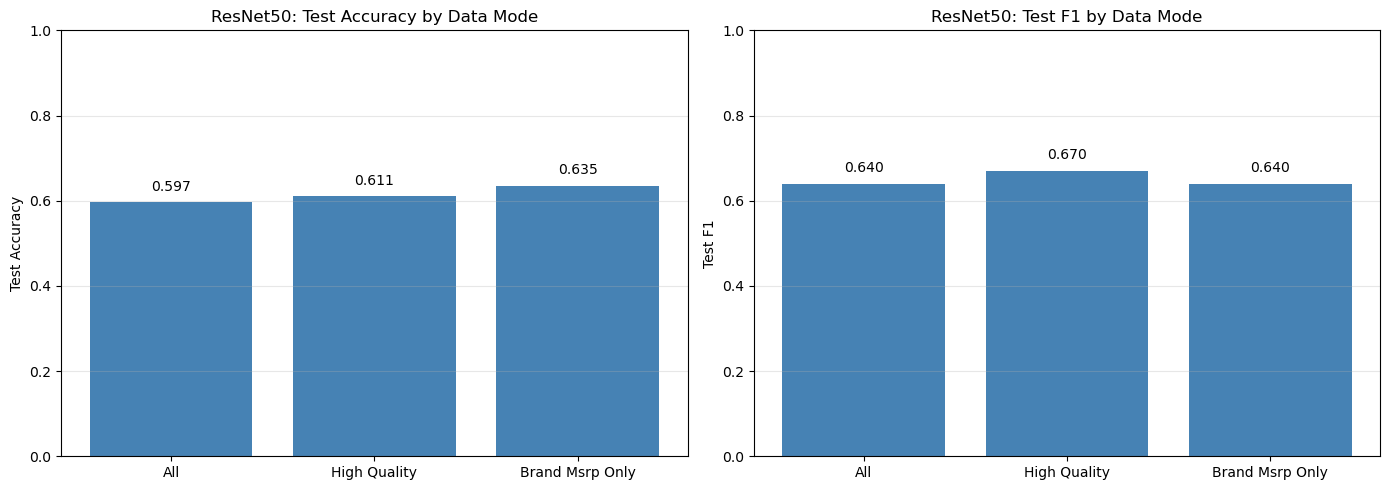

In [8]:
import matplotlib.pyplot as plt

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Data Mode': mode.replace('_', ' ').title(),
        'Train Size': results['train_samples'],
        'Test Accuracy': results['test_accuracy'],
        'Test F1': results['test_f1'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall']
    }
    for mode, results in all_results.items()
])

print("\n" + "="*80)
print("RESNET50 RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Test Accuracy', 'Test F1']
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df['Data Mode'], comparison_df[metric], color='steelblue')
    ax.set_ylabel(metric)
    ax.set_title(f'ResNet50: {metric} by Data Mode')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet50_comparison.png', dpi=300, bbox_inches='tight')
plt.show()